In [13]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import datetime
plt.ion()   # interactive mode

PATH = os.getcwd() + "/checkpoint/latestmodelv2.pt"

In [14]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
batch_size = 128
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=data_transforms['train'])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=8)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=data_transforms['val'])
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=8)

dataloaders = {'train': trainloader , 'val': testloader }

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dataset_sizes = {'train': len(trainset) , 'val': len(testset) }

Files already downloaded and verified
Files already downloaded and verified


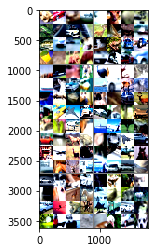

 frog   car  deer plane


In [15]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [16]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    #best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    val_loss= 100
    val_acc = -1
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step(val_loss)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == 'val':
                val_loss = epoch_loss
                val_acc = epoch_acc

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            print( "Epoch Finish Time: ", datetime.datetime.now() )

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                #best_model_wts = copy.deepcopy(model.state_dict())
                
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'val_loss': val_loss,
                'val_acc' : val_acc,
                
            }, PATH)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [5]:
#Model Def
m = models.resnet50()
m.fc = nn.Linear(2048, len(classes))

m = m.to(device)


criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(m.parameters(), lr=0.1, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=90, gamma=0.1)
#exp_lr_scheduler = ReduceLROnPlateau( optimizer_conv,patience=5,min_lr=0.5e-6)

In [ ]:
print("Training Start Time: ", datetime.datetime.now() )
m = train_model(m, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=350)

Training Start Time:  2019-12-11 16:58:32.410439
Epoch 0/349
----------
train Loss: 2.6184 Acc: 0.1775
Epoch Finish Time:  2019-12-11 17:01:01.067130
val Loss: 2.0597 Acc: 0.2350
Epoch Finish Time:  2019-12-11 17:01:13.198899

Epoch 1/349
----------
train Loss: 1.9770 Acc: 0.2533
Epoch Finish Time:  2019-12-11 17:03:42.360549
val Loss: 1.8755 Acc: 0.3122
Epoch Finish Time:  2019-12-11 17:03:55.719838

Epoch 2/349
----------
train Loss: 1.9158 Acc: 0.2809
Epoch Finish Time:  2019-12-11 17:06:24.931800
val Loss: 1.7174 Acc: 0.3657
Epoch Finish Time:  2019-12-11 17:06:38.229977

Epoch 3/349
----------
train Loss: 1.7752 Acc: 0.3411
Epoch Finish Time:  2019-12-11 17:09:07.227354
val Loss: 1.5761 Acc: 0.4260
Epoch Finish Time:  2019-12-11 17:09:20.837421

Epoch 4/349
----------
train Loss: 1.6874 Acc: 0.3771
Epoch Finish Time:  2019-12-11 17:11:50.469967
val Loss: 1.5051 Acc: 0.4499
Epoch Finish Time:  2019-12-11 17:12:03.913544

Epoch 5/349
----------
train Loss: 1.6073 Acc: 0.4127
Epoch F

In [12]:
#  Pipe Break- reloading from checkpoint
# Model Def
m = models.resnet50()
m.fc = nn.Linear(2048, len(classes))
m = m.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(m.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=100, gamma=0.1)
#exp_lr_scheduler = ReduceLROnPlateau( optimizer_conv,patience=5,min_lr=0.5e-6)

checkpoint = torch.load(PATH)
m.load_state_dict(checkpoint['model_state_dict'])

optimizer_conv.load_state_dict(checkpoint['optimizer_state_dict'])
#exp_lr_scheduler.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['val_loss']

print("Training Start Time: ", datetime.datetime.now(), "Epoch: ", str(epoch) )
m = train_model(m, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=350-(epoch+1))

Training Start Time:  2019-12-11 22:27:32.785435 Epoch:  121
Epoch 0/227
----------
train Loss: 0.2735 Acc: 0.9062
Epoch Finish Time:  2019-12-11 22:30:01.075008
val Loss: 0.3399 Acc: 0.9119
Epoch Finish Time:  2019-12-11 22:30:13.471261

Epoch 1/227
----------
train Loss: 0.2583 Acc: 0.9106
Epoch Finish Time:  2019-12-11 22:32:41.856042
val Loss: 0.3091 Acc: 0.9137
Epoch Finish Time:  2019-12-11 22:32:54.379867

Epoch 2/227
----------
train Loss: 0.2527 Acc: 0.9124
Epoch Finish Time:  2019-12-11 22:35:23.019365
val Loss: 0.3076 Acc: 0.9166
Epoch Finish Time:  2019-12-11 22:35:35.465019

Epoch 3/227
----------
train Loss: 0.2450 Acc: 0.9154
Epoch Finish Time:  2019-12-11 22:38:04.089098
val Loss: 0.3082 Acc: 0.9169
Epoch Finish Time:  2019-12-11 22:38:16.340043

Epoch 4/227
----------
train Loss: 0.2405 Acc: 0.9174
Epoch Finish Time:  2019-12-11 22:40:45.004221
val Loss: 0.3202 Acc: 0.9160
Epoch Finish Time:  2019-12-11 22:40:58.481369

Epoch 5/227
----------
train Loss: 0.2326 Acc: 0.

KeyboardInterrupt: 

In [17]:
#  Pipe Break- reloading from checkpoint
# Model Def
m = models.resnet50()
m.fc = nn.Linear(2048, len(classes))
m = m.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(m.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=100, gamma=0.1)
#exp_lr_scheduler = ReduceLROnPlateau( optimizer_conv,patience=5,min_lr=0.5e-6)

checkpoint = torch.load(PATH)
m.load_state_dict(checkpoint['model_state_dict'])

optimizer_conv.load_state_dict(checkpoint['optimizer_state_dict'])
#exp_lr_scheduler.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['val_loss']

print("Training Start Time: ", datetime.datetime.now(), "Epoch: ", str(epoch) )
m = train_model(m, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=350-(epoch+1))

Training Start Time:  2019-12-12 02:05:37.842983 Epoch:  9
Epoch 0/339
----------
train Loss: 0.2219 Acc: 0.9236
Epoch Finish Time:  2019-12-12 02:08:06.397568
val Loss: 0.2981 Acc: 0.9207
Epoch Finish Time:  2019-12-12 02:08:18.852337

Epoch 1/339
----------
train Loss: 0.2229 Acc: 0.9229
Epoch Finish Time:  2019-12-12 02:10:47.530429
val Loss: 0.3006 Acc: 0.9205
Epoch Finish Time:  2019-12-12 02:11:00.007218

Epoch 2/339
----------
train Loss: 0.2202 Acc: 0.9238
Epoch Finish Time:  2019-12-12 02:13:28.538922
val Loss: 0.2978 Acc: 0.9215
Epoch Finish Time:  2019-12-12 02:13:40.887699

Epoch 3/339
----------
train Loss: 0.2240 Acc: 0.9239
Epoch Finish Time:  2019-12-12 02:16:09.732234
val Loss: 0.3016 Acc: 0.9214
Epoch Finish Time:  2019-12-12 02:16:22.263576

Epoch 4/339
----------


KeyboardInterrupt: 

In [30]:
#model for evaluation
#Model Def
m = models.resnet50()
m.fc = nn.Linear(2048, len(classes))
m = m.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(m.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=100, gamma=0.1)

checkpoint = torch.load(PATH)
m.load_state_dict(checkpoint['model_state_dict'])
optimizer_conv.load_state_dict(checkpoint['optimizer_state_dict'])
#exp_lr_scheduler.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['val_loss']
m.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [31]:
from PIL import Image
from torchvision import transforms

def eval_image( filepath ):
    input_image = Image.open(filepath )
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        m.to('cuda')

    with torch.no_grad():
        output = m(input_batch)
    # The output has unnormalized scores. To get probabilities, you can run a softmax on it.
    #print(torch.nn.functional.softmax(output[0], dim=0))
    _, preds = torch.max(output, 1)
    return preds[0]

In [32]:
from os import listdir
classes_new = ('airplane', 'automobile', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
image_paths = [
    listdir("DSF_HW5_wild_images/%d_%s" % ( num, c_name ))
    for num, c_name in enumerate(classes_new)
]

correct = 0.0
total = 0.0
for actual_class,files in enumerate(image_paths):
    for image_filepath in files:
        fpath = "DSF_HW5_wild_images/%d_%s/" % ( actual_class, classes_new[actual_class] )
        pred_label = eval_image( fpath + image_filepath )
        if pred_label == actual_class:
            correct += 1.0
       
        total += 1.0

print( "Wild Accuracy: ", correct / total )

Wild Accuracy:  0.98


In [36]:
device

device(type='cuda', index=0)